In [1]:
# Author: Andi Sama
# Organization: Sinergi Wahana Gemilang
#   a Value Added Distributor in Jakarta, Indonesia
# Created: June 18, 2018
# Last modified:
#   - June 19, 2018
#     * Add a few more information during training by modifying code in network_asm.py
#       (% on classification rate & elapsed time per epoch + total elapsed time for all epochs)
#     * Add a few more information during training by modifying code in mnist_loader_asm.py
#       (loaded data sizes)
#   - June 21, 2018
#     * Apply cross-entropy on cost function (previously: use quadratic cost) to improve accuracy
#     * Apply Mini-batch gradient descent (previously: just Stochastic Gradient Descent)
#     * Add monitor_elapsed_time flag in network2_asm.py
#     * Draw plot for training cost, evaluation cost against # of epoch
#     * Use Gaussian distributions with mean 0 and standard deviation 1 over the square root
#       of the number of weights connecting to the same neuron for network initialization
#       (previously: Gaussian distribution without square root)
#   - June 23, 2018
#     * Use regularization - lambda 
#     * Visualization of mnist dataset
#   - June 24, 2018
#       Add predict() function use existing function load() network after save()
#       => vanilla version done
#   - June 24, 2018
#     * use mnist testing dataset to predict (now still using training data)
#   - June 25-26, 2018
#     * migrate to IBM Watson Studio (on cloud)
#       - upload all files to IBM object storage
#       - get all files to working directory by using IBM boto3 api
#       - convert code from python 2.7 to 3.5 (print function, cPickle handler, xrange)
# Topic: Beginning Deep Learning (computer vision)
# Purpose: Recognizing handwritten digits 0-9 in 3 steps
#   - 1. Prepare datasets (MNIST, modified nist database)
#   - 2. Train, Validate on datasets to generate deep learning model (architecture, weights)
#   - 3. Predict new data based on generated model with testing data 
# Type of Neural Network: Supervised Learning with shallow neural network
#   Dataset: mnist
#     - original training dataset (60,000): handwritten digits from 250 persons (2 groups)
#       further then divided to be 50,000 for training dataset and 10,000 for validation dataset
#     - testing dataset (10,000): handwritten digits from another set of 250 persons (2 groups)
# Hardware & Software platforms:
#   - environment: cygwin on Windows, on Thinkpad T450 (i7 4 vCPUs without GPUs, 16 GB RAM)
#   - programming language: python (v2.7)
#   - deep learning framework: none
#   - libraries: sys, pandas, numpy, math, matplotlib
# Reference:
#   - Michael A. Nielsen, "Neural Network & Deep Learning",
#     Determination Press, 2015 http://neuralnetworksanddeeplearning.com 
#     Original code from the book is at https://github.com/mnielsen/neural-networks-and-deep-learning
#   - various references from stackoverflow, github, and related library documentations etc

In [2]:
!ls -al

total 17552
drwxr-x--- 3 dsxuser dsxuser     4096 Jun 26 02:32 .
drwx------ 1 dsxuser dsxuser     4096 Jun 26 01:59 ..
-rw-r----- 1 dsxuser dsxuser   848414 Jun 26 02:20 2018624223944_asm_Trained_NN
-rw-r----- 1 dsxuser dsxuser     4672 Jun 26 02:20 mnist_loader_asm_py3.py
-rw-r----- 1 dsxuser dsxuser 17051982 Jun 26 02:20 mnist.pkl.gz
-rw-r----- 1 dsxuser dsxuser     5438 Jun 26 02:32 mnist_plot0.png
-rw-r----- 1 dsxuser dsxuser     4914 Jun 26 02:32 mnist_plot1.png
-rw-r----- 1 dsxuser dsxuser     5211 Jun 26 02:32 mnist_plot2.png
-rw-r----- 1 dsxuser dsxuser    16409 Jun 26 02:20 network2_asm_b_py3.py
drwxr-x--- 2 dsxuser dsxuser     4096 Jun 26 02:07 __pycache__


In [3]:
# The code was removed by DSX for sharing.

In [4]:
!ls -al

total 17552
drwxr-x--- 3 dsxuser dsxuser     4096 Jun 26 02:32 .
drwx------ 1 dsxuser dsxuser     4096 Jun 26 01:59 ..
-rw-r----- 1 dsxuser dsxuser   848414 Jun 26 03:16 2018624223944_asm_Trained_NN
-rw-r----- 1 dsxuser dsxuser     4672 Jun 26 03:16 mnist_loader_asm_py3.py
-rw-r----- 1 dsxuser dsxuser 17051982 Jun 26 03:16 mnist.pkl.gz
-rw-r----- 1 dsxuser dsxuser     5438 Jun 26 02:32 mnist_plot0.png
-rw-r----- 1 dsxuser dsxuser     4914 Jun 26 02:32 mnist_plot1.png
-rw-r----- 1 dsxuser dsxuser     5211 Jun 26 02:32 mnist_plot2.png
-rw-r----- 1 dsxuser dsxuser    16406 Jun 26 03:16 network2_asm_b_py3.py
drwxr-x--- 2 dsxuser dsxuser     4096 Jun 26 02:07 __pycache__


In [5]:
# !cat mnist_loader_asm_py3.py 

In [6]:
import sys
import matplotlib.pyplot as plt # graphic related things
import numpy as np
import math
import pandas as pd # dataframe manipulation
import mnist_loader_asm_py3 # helper program for loading mnist data set
import network2_asm_b_py3 # helper program, neural network layers

In [7]:
#plot individual curve: training training/evaluation accuracy, training/evaluation cost
def plot_curve(xlabel, epoch, ylabel, loss):
    # epoch: total epoch, loss: list of lost values for all epochs
    epochs = []
    for i in range(epoch):
        epochs.append(i)
    plt.plot(epochs,loss)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
#compare training & evaluation accuracy / cost
def plot_curve_comparison(epoch, title, xlabel, data1, ylabel, data2):
    epochs = []
    for i in range(epoch):
        epochs.append(i)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(epochs, data1, label=xlabel)
    ax.plot(epochs, data2, label=ylabel)
    plt.title(title)
    ax.legend()
    plt.show()

In [8]:
# ========================
# 1. LOAD Dataset (MNIST)
# ========================
# 1a. load mnist data using mnist_loader library
#   output is structured in such a way to fit and be ready for learning
#   each data is in 784x1 dimension, reshape to 28x28 pixels for viewing
#   each label is in 8x1 dimension,
#     extract array content with "1" in it to get the actual label ["0".."9"]
#

#training_data, validation_data, test_data = mnist_loader_asm_py3.load_data_wrapper()
zip_training_data, zip_validation_data, zip_test_data = mnist_loader_asm_py3.load_data_wrapper()

>> Training dataset (x, y)], length: 2 arrays.
  - 1st array (data, x) 28x28 pixels; total data: 50000 , length per data: 784
  - 2nd array (target label, y) [0..9]; total data: 50000
    sample dataset: 5


In [9]:
training_data = list(zip_training_data)
validation_data = list(zip_validation_data)
test_data = list(zip_test_data)

A few samples for the 28x28 pixels mnist digit dataset with its corresponding label


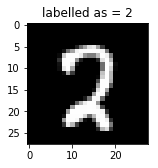

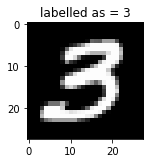

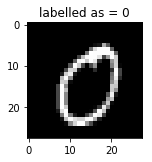

In [24]:
# 1b. just show a few sample digits with its corresponding labels
#
print("A few samples for the 28x28 pixels mnist digit dataset with its corresponding label")
row = 1
column = 3
np.random.shuffle(training_data) # just resuffle so we are showing different data when refreshed
for i in range(column):
    #get corresponding target label (y) "digit" from its vectorized format
    data = training_data[i][1]
    digit=0
    j=0
    for x in data:
        if int(x):
            digit=j
            break
        else:
            j=j+1
    #then, plot the image data 
    image = training_data[i][0].reshape(28, 28)   
    plt.subplot(row, column, i+1)  # subplot with size  
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    plt.title('labelled as = {0}'.format(digit))
    plt.axis('on')  # do not show axis value
    plt.tight_layout()  # automatic padding between subplots
    filename = "mnist_plot"+str(i)+".png"
    plt.savefig(filename)
    plt.show()

In [32]:
# ==================================================
# 2. TRAIN the Neural Network (SUPERVISED LEARNING)
# ==================================================
# 2a. first Create Neural Network Architecture (Input, Hidden Layers(), Output)
# setting up input layers for 28 x 28 pixels mnist input image size = 784 input neurons
# the following hyper-parameters are initially set
#
input_neurons  = 784  # 1st layer, input layer
hidden_neurons = 50  # 2nd layer, 1st hidden layers
output_neurons = 10  # nth layer, output layer
# then define the network (now: 1 hidden layers; can be multiple)
net = network2_asm_b_py3.Network([input_neurons, hidden_neurons, output_neurons],
    cost=network2_asm_b_py3.CrossEntropyCost)
net.default_weight_initializer()

In [36]:
# 2b. then, train the network (supervised learning)
#  generate weights, biases for all defined neural network hidden nodes
#
# prepare to run with additional hyper-parameters
lr = 0.25 # learning rate
mini_batch_size = 16
epoch = 50
# the following training will take some few minutes to hours in total to run (on Thinkpad T450)
#   using Back Propagation (Mini-batch GD - Mini-batch Gradient Descent). epoch starts at 0
#   [experiment 1]: Total time for 30 Epochs are 669.534558058 seconds
#     with learning rate = 0.5, 1st hidden neurons = 30 & mini batch size = 10, epoch = 30
#       * at Epoch 0 - completed in 14.201 seconds
#           train cost:0.592158354923, eval cost:0.583742260415
#           train acc:91.148%, eval acc:91.38%
#       * at Epoch 17 - completed in 12.691 seconds
#           train cost:0.234122439643, eval cost:0.357925843064
#           train acc:96.826%, eval acc:94.59%
#       * at Epoch 29 - completed in 12.728 seconds
#           train cost:0.197905372636, eval cost:0.380761454796
#           train acc:97.424%, eval acc:94.91%
#   [experiment 2]: Total time for 30 Epochs are 5535.98018217 seconds
#     by keeping other parameters unchanged and change only 1st hidden neurons = 100  
#       * at Epoch 0 - completed in 172.04 seconds
#           train cost:0.483291977803, eval cost:0.505009341819
#           train acc:93.266%, eval acc:92.85%
#       * at Epoch 12 - completed in 162.898 seconds
#           train cost:0.0828427459533, eval cost:0.285776222999
#           train acc:99.206%, eval acc:96.7%
#       * at Epoch 29 - completed in 167.119 seconds
#           train cost:0.0162023169185, eval cost:0.331588846324
#           train acc:99.94%, eval acc:96.78%
#   [experiment 3]: Total time for 30 Epochs are 2042.2370491 seconds
#     with learning rate changed to 0.25, 1st hidden neurons increased to 50
#          keep mini batch size = 10 and epoch = 30, lambda (regularization) = 5
#       * at Epoch 0 - completed in 97.323 seconds
#           train cost:0.396410205065, eval cost:0.414407693281
#           train acc:94.108%, eval acc:93.79%
#       * at Epoch 16 - completed in 53.617 seconds
#           train cost:0.0840871412076, eval cost:0.236337866115
#           train acc:99.21%, eval acc:96.77%
#       * at Epoch 29 - completed in 53.553 seconds
#           train cost:0.0471638578835, eval cost:0.275443772384
#           train acc:99.69%, eval acc:96.69%
#
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = \
    net.SGD(training_data, epoch, mini_batch_size, lr, evaluation_data=test_data, lmbda=3,
    monitor_all=True)

>>> TRAINING STARTS...
Epoch 0  training complete
  train cost: 0.217648242775 , eval cost: 0.613001175167
  train acc: 98.528 % , eval acc: 96.74 %
  Epoch  0 completed in 10.364 seconds
Epoch 1  training complete
  train cost: 0.210657830026 , eval cost: 0.621040452382
  train acc: 98.726 % , eval acc: 97.12 %
  Epoch  1 completed in 10.292 seconds
Epoch 2  training complete
  train cost: 0.202932625253 , eval cost: 0.626426720006
  train acc: 98.816 % , eval acc: 97.13 %
  Epoch  2 completed in 10.231 seconds
Epoch 3  training complete
  train cost: 0.204895882317 , eval cost: 0.633956028558
  train acc: 98.842 % , eval acc: 97.23 %
  Epoch  3 completed in 10.775 seconds
Epoch 4  training complete
  train cost: 0.208851269742 , eval cost: 0.643769703338
  train acc: 98.874 % , eval acc: 97.14 %
  Epoch  4 completed in 10.399 seconds
Epoch 5  training complete
  train cost: 0.21246012647 , eval cost: 0.661922977204
  train acc: 98.714 % , eval acc: 96.84 %
  Epoch  5 completed in 10.

In [15]:
# 2c. save the last trained network sizes, weights, biases, cost
#
# generate current time to be embedded in filename
import time
dt = time.localtime(time.time())
i=0
prefix = ""
while i<6:
    #print str(dt[i])
    prefix = prefix + str(dt[i])
    i=i+1
# embed the current time in file name
filename = prefix + "_asm_Trained_NN"
print("saving:", filename, "...")
net.save(filename)
print("done.")

saving: 201862632812_asm_Trained_NN ...
done.


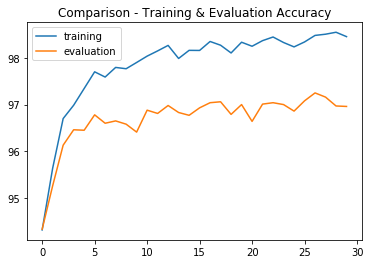

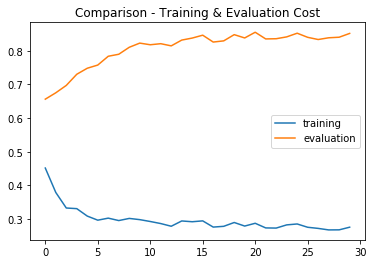

In [16]:
# 2d. plot comparison curve: accuracy & cost, for both training & evaluation
#
plot_curve_comparison(epoch, "Comparison - Training & Evaluation Accuracy", \
                      "training", training_accuracy, "evaluation", evaluation_accuracy)
plot_curve_comparison(epoch, "Comparison - Training & Evaluation Cost", \
                      "training", training_cost, "evaluation", evaluation_cost)

In [ ]:
# 2.e drawing each curve one at a time (optional)
# #draw the curve - x for epoch and y for training cost
# plot_curve("epoch", epoch, "training loss", training_cost)
# #draw the curve - x for epoch and y for training accuracy
# plot_curve("epoch", epoch, "training accuracy", training_accuracy)
# #draw the curve - x for epoch and y for evaluation cost
# plot_curve("epoch", epoch, "evaluation loss", evaluation_cost)
# #draw the curve - x for epoch and y for evaluation accuracy
# plot_curve("epoch", epoch, "evaluation accuracy", evaluation_accuracy)

A digit to predict from mnist testing dataset
label:6, predicted:6, conf_lvl:99.998%


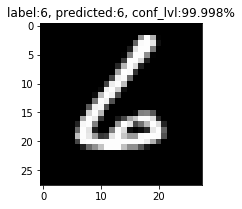

label:0, predicted:0, conf_lvl:99.972%


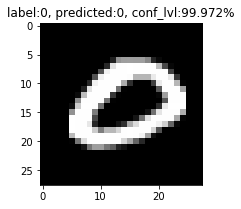

In [21]:
# 3. PREDICT New Image, based on saved network
#
# 3a. 1st, load the previously saved network 
filename = "2018624223944_asm_Trained_NN"
mynet = network2_asm_b_py3.load(filename)

# 3b. define predict() function
def predict(network, x):        
    # feedforward to predict with trained weights, biases
    # network: trained neural network, x: new images
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    i=0
    for b, w in zip(network.biases, network.weights):
        i=i+1
        z = np.dot(w, activation)+b
        activation = sigmoid(z)
    #extracting highest confidence level from feed forward output
    digit=0
    confidence_level = 0.0
    threshold = 0.5
    j=0
    for i in activation: # output from the last layer
        if i >= threshold:
            digit=j
            confidence_level = i
            break
        else:
            j=j+1
    #print "predicted digit: {0}, confidence level: {1}%".format(digit, float(confidence_level)*100)
    conf_level = float(confidence_level*100)
    return digit, conf_level
            
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# 3c. then, predict 
# get a digit from new image
print("A digit to predict from mnist testing dataset")

row = 1
column = 2
# just resuffle so we are showing different data when refreshed, from mnist test dataset
np.random.shuffle(test_data) 
for i in range(column):
    #get corresponding target label (y) "digit" from its vectorized format
    digit_label = test_data[i][1]
    # finally, call predict() to predict a new image
    image = test_data[i][0] 
    digit_predicted, conf_level = predict(mynet, image)
    title = "label:{0}, predicted:{1}, conf_lvl:{2}%".format(digit_label, \
        digit_predicted, float(math.trunc(conf_level*1000))/1000)
    print(title)
    #then, plot the image data with title "labelled digit, predicted digit + its confidence level" 
    image = test_data[i][0].reshape(28, 28)   
    plt.subplot(row, column, 1)  # subplot with size  
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    #plt.title("label:{0}, predicted:{0}, conf_lvl:{1}%".format(digit_label, digit_predicted, conf_level))
    plt.title(title)
    plt.axis("on") # show axis value
    plt.tight_layout() # automatic padding between subplots
    plt.show()

In [22]:
!ls -al

total 18404
drwxr-x--- 3 dsxuser dsxuser     4096 Jun 26 03:28 .
drwx------ 1 dsxuser dsxuser     4096 Jun 26 01:59 ..
-rw-r----- 1 dsxuser dsxuser   848414 Jun 26 03:16 2018624223944_asm_Trained_NN
-rw-r----- 1 dsxuser dsxuser   871135 Jun 26 03:28 201862632812_asm_Trained_NN
-rw-r----- 1 dsxuser dsxuser     4672 Jun 26 03:16 mnist_loader_asm_py3.py
-rw-r----- 1 dsxuser dsxuser 17051982 Jun 26 03:16 mnist.pkl.gz
-rw-r----- 1 dsxuser dsxuser     5805 Jun 26 03:16 mnist_plot0.png
-rw-r----- 1 dsxuser dsxuser     5252 Jun 26 03:16 mnist_plot1.png
-rw-r----- 1 dsxuser dsxuser     5354 Jun 26 03:16 mnist_plot2.png
-rw-r----- 1 dsxuser dsxuser    16406 Jun 26 03:16 network2_asm_b_py3.py
drwxr-x--- 2 dsxuser dsxuser     4096 Jun 26 03:16 __pycache__
